This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [28]:
NUMBER_OF_BATCHES = 500
BATCH_SIZE = 10
NUMBER_OF_GAMES = NUMBER_OF_BATCHES * BATCH_SIZE

In [3]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        #return 0.5 / (1 + rate_val * turn) 

        return 0.5 * np.exp(-rate_val * turn) #my new proposed fucntion

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + max_rate * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        #return 1 + (max_rate - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
        return np.pow(10000, np.pow(turn/(NUMBER_OF_GAMES), rate_val )) #my new proposed function

    return tau


In [4]:

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [5]:
alpha_exponents = np.linspace(-4, -10, 10)
alpha_values = np.pow(10, alpha_exponents)
tau_exponents = np.linspace(-3, 3, 10 )
tau_values = np.pow(10, tau_exponents)
print(alpha_values)
print(tau_values)
print(tau_exponents)



[1.00000000e-04 2.15443469e-05 4.64158883e-06 1.00000000e-06
 2.15443469e-07 4.64158883e-08 1.00000000e-08 2.15443469e-09
 4.64158883e-10 1.00000000e-10]
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


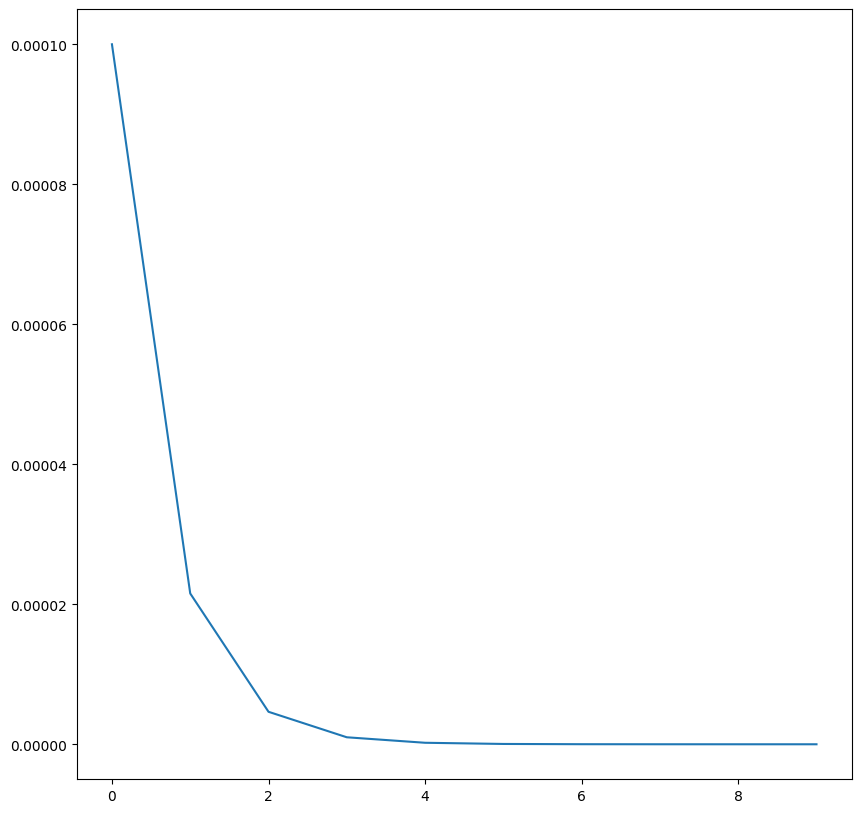

In [6]:
fig, axes = plt.subplots(figsize=(10, 10))

x = np.arange(0, len(alpha_values))

axes.plot(x, alpha_values)
#axes.plot(x, tau_values)

In [7]:
def try_different_hyperparams(alpha_rates, tau_rates, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_rate in enumerate(tau_rates):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_rate))

            results = results/(BATCH_SIZE * 50)
        
            #records the resultsplayer_x_label='x', player_o_label='o', 
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_rate}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_rate, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)

            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_rate}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [8]:
#try_different_hyperparams(alpha_values, tau_values, 'x', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'x', 'random')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'random')


In [9]:
df = pd.read_csv('parameter_results/analysis_4/x_vs_random/hyperparams.csv')

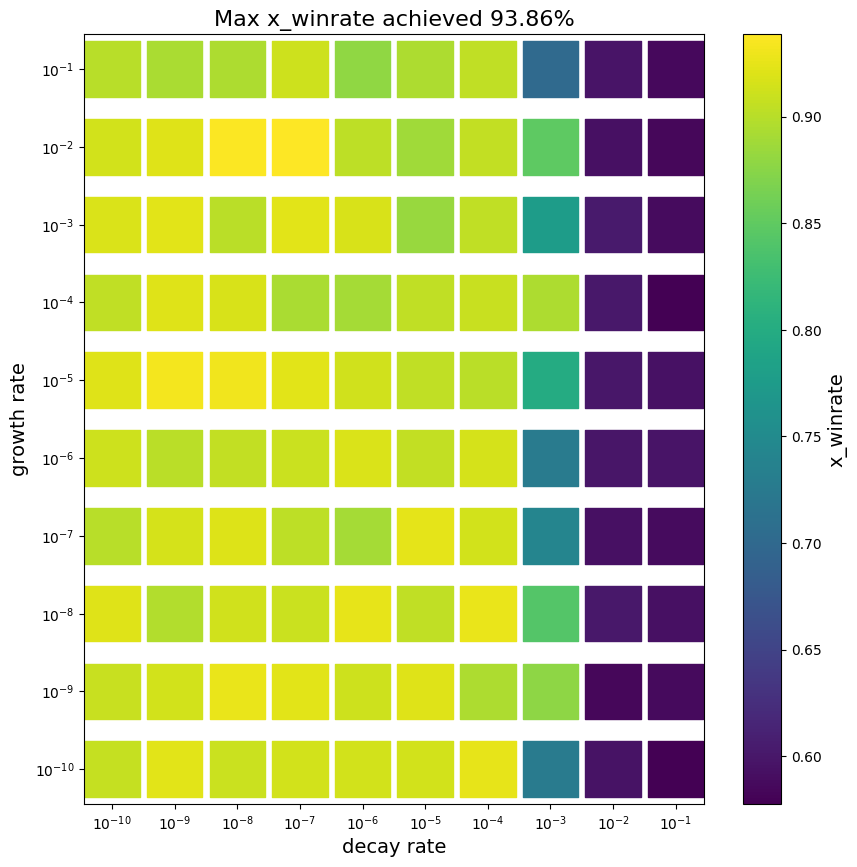

In [10]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Filter data
mask = df[np.log10(df['tau_rate']) < 1]

x = np.log10(mask['alpha_rate'])
y = np.log10(mask['tau_rate'])
z = mask['x_winrate']

# 2. Plotting
scatter = ax.scatter(x, y, c=z, s=1600, cmap='viridis', marker='s') # marker='s' often looks better for grid searches

# --- THE FORMATTING PART ---
def log_formatter(x, pos):
    return f"$10^{{{int(x)}}}$"

# Apply formatter to X axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))
# Apply formatter to Y axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))

# Ensure ticks stay at integer intervals (prevents 10^-4.5)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# ---------------------------

# 3. Colorbar and Labels
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(z.name, size=14)

# Use LaTeX for the Greek letters alpha and tau
ax.set_xlabel(r'decay rate', fontsize=14)
ax.set_ylabel(r'growth rate', fontsize=14)
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%", fontsize=16)

plt.show()

I have found good parameters for alpha rate and tau rate which should be implemented:

alpha_rate 10^-7

tau_rate = 10^-0.333


Now the goal is to create a matrix:

I will train 4 models on those parameters and record the results after playing 1000 games against each other using tau as the softmax

In [11]:
alpha = make_alpha(np.pow(10.0, -7))
tau = make_tau(np.pow(10.0, -1/3))


In [12]:

Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_X_Random, results = qlb.perform_training('x', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Perfect, results = qlb.perform_training('o', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Random, results = qlb.perform_training('o', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])

[  7 493   0]
[ 20  22 458]
[  0 492   8]
[298  51 151]


In [13]:
results[-1, :]/5

array([59.6, 10.2, 30.2])

o win   draw    x win
0
90.00%   10.00%   0.00%
50
72.40%   27.60%   0.00%
100
39.40%   60.60%   0.00%
150
21.40%   78.60%   0.00%
200
10.00%   90.00%   0.00%
250
7.20%   92.80%   0.00%
300
3.20%   96.80%   0.00%
350
3.40%   96.60%   0.00%
400
1.60%   98.40%   0.00%
450
1.40%   98.60%   0.00%


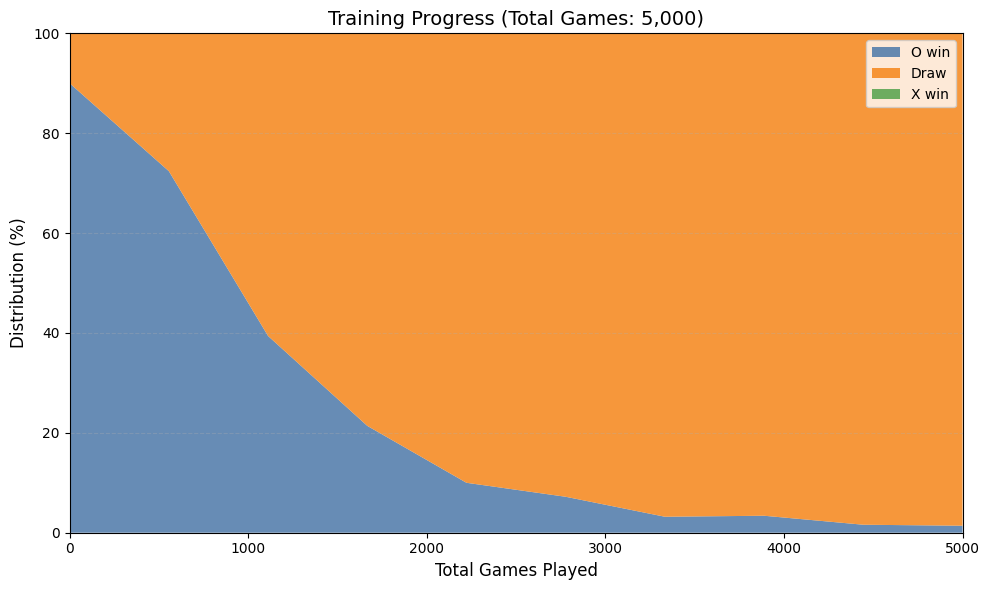

In [ ]:
Q_Table_X_Random, results = qlb.perform_training('x', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, True, alpha, tau)
qlb.plot_training_results(results, BATCH_SIZE, NUMBER_OF_BATCHES)

In [15]:

number_of_games_in_the_match = 10000
results_x_perfect_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
results_x_perfect_vs_o_random = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_random = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_fully_random_game = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 1)
results_another_fully_random_game = qlb.play_random_match(number_of_games_in_the_match)

results_from_matches = [results_x_perfect_vs_o_perfect, results_x_perfect_vs_o_random, results_x_random_vs_o_perfect, results_x_random_vs_o_random, results_fully_random_game, results_another_fully_random_game]

for result_from_match in results_from_matches:
    
    print(result_from_match/np.sum(result_from_match))


[0.2785 0.1324 0.5891]
[0.4652 0.1374 0.3974]
[0.2827 0.1388 0.5785]
[0.4663 0.1408 0.3929]
[0.2954 0.1259 0.5787]
[0.2874 0.1246 0.588 ]


**Final results are:**

[0.2699  0.1412 0.5889]

[0.6103 0.2324 0.1573]

[0.0559 0.0836 0.8605]

[0.2667 0.3002 0.4331]


***Next stage is to compare the theoretically generated Q-Tables and the actual Q-Table that was made during learning***

In [16]:
#comparing perfect Q-Tables

perfect_theoretical_Q_Table = qlb.import_perfect_Q_Table()

for state in perfect_theoretical_Q_Table:
    
    if state.count("_") % 2 == 1:
        
        if qlb.check_result(state) == 2:

            print(state)
            print(perfect_theoretical_Q_Table[state])
            print(Q_Table_X_Perfect[state])

ox_xoxoox
[nan nan  1. nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxo_oox
[nan nan nan nan nan  1. nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxoxoo_
[nan nan nan nan nan nan nan nan  1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxo_xxoox
[nan nan nan  1. nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxox_xoox
[nan nan nan nan  1. nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxoxx_oox
[nan nan nan nan nan  1. nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
_xooxxxoo
[ 0. nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_ooxxxoo
[nan  0. nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxoo_xxoo
[nan nan nan nan  0. nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxoox_xoo
[nan nan nan nan nan  0. nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxooxx_oo
[nan nan nan nan nan nan  0. nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
o_xxxooox
[nan  0. nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ox_xxooox
[nan nan  0. nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [17]:
#comparing random Q-Tables

random_theoretical_Q_Table = qlb.import_perfect_Q_Table("data_exports/random_Q_Table.json")

for state in random_theoretical_Q_Table:
    
    if state.count("_") % 2 == 1:
        
        if qlb.check_result(state) == 2:

            print(state)
            print(random_theoretical_Q_Table[state])
            print(Q_Table_X_Random[state])

oo_xxooxx
[nan nan  0. nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oox_xooxx
[nan nan nan  0. nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxx_ooxx
[nan nan nan nan  0. nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxxxoo_x
[nan nan nan nan nan nan nan  0. nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxxxoox_
[nan nan nan nan nan nan nan nan  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
o_xxooxox
[nan  0. nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ox_xooxox
[nan nan  0. nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxx_ooxox
[nan nan nan  0. nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxoo_ox
[nan nan nan nan nan nan  0. nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxooxo_
[nan nan nan nan nan nan nan nan  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
o_ooxxxxo
[nan  1. nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxoo_xxxo
[nan nan nan nan  1. nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxooxxx_o
[nan nan nan nan nan nan nan  1. nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [18]:
perfect_theoretical_Q_Table['_______ox']

array([ 0.,  0.,  1.,  0.,  1.,  1.,  0., nan, nan])

Good results, I have implemented that into my report. Now I will generate some graphs for report


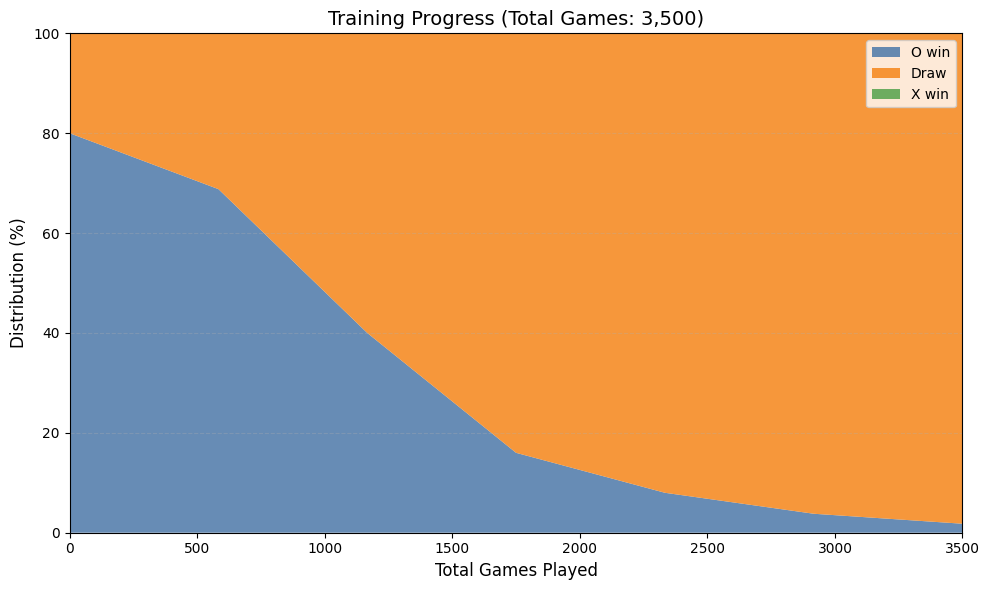

In [24]:
#No Learning over 1000 batches of 10 (hyperparameter tau = 1, alpha = 0, means that )

qlb.plot_training_results(results, BATCH_SIZE, NUMBER_OF_BATCHES)

In [20]:
results

array([[  8,   2,   0],
       [344, 156,   0],
       [200, 300,   0],
       [ 80, 420,   0],
       [ 40, 460,   0],
       [ 19, 481,   0],
       [  9, 491,   0]])

In [21]:
results[:, 0]/(366+134) < 0.05

array([ True, False, False, False, False,  True,  True])

In [22]:
# Train via Q-Learning (Existing)
q_table_td, results_td = qlb.perform_training('x', opponent_type='random', number_of_batches=NUMBER_OF_BATCHES, batch_size=BATCH_SIZE)

# Train via Monte Carlo (New)
q_table_mc, results_mc = qlb.perform_training_MC_incremental('x', opponent_type='random')


o win   draw    x win
0
20.00%   0.00%   80.00%
50
27.40%   13.60%   59.00%
100
30.60%   10.60%   58.80%
150
29.60%   13.20%   57.20%
200
27.20%   12.40%   60.40%
250
28.00%   13.20%   58.80%
300
23.60%   12.40%   64.00%
Training x via Incremental Monte Carlo...
o win   draw    x win
50
27.60%   12.60%   59.80%
100
24.80%   8.40%   66.80%
150
23.60%   8.40%   68.00%
200
14.80%   9.60%   75.60%
250
15.80%   9.80%   74.40%
300
13.60%   6.40%   80.00%
350
11.20%   7.20%   81.60%
400
10.20%   8.60%   81.20%
450
10.80%   6.00%   83.20%
500
6.60%   8.80%   84.60%
550
9.80%   5.80%   84.40%
600
6.80%   6.60%   86.60%
650
7.00%   7.60%   85.40%
700
6.60%   4.60%   88.80%
750
8.00%   5.40%   86.60%
800
7.80%   7.00%   85.20%
850
5.60%   4.80%   89.60%
900
6.60%   5.60%   87.80%
950
7.80%   5.60%   86.60%
1000
5.00%   6.80%   88.20%
1050
5.40%   7.40%   87.20%
1100
5.20%   4.00%   90.80%
1150
7.40%   5.00%   87.60%
1200
3.80%   4.80%   91.40%
1250
3.80%   7.20%   89.00%
1300
2.80%   5.80%   91.4

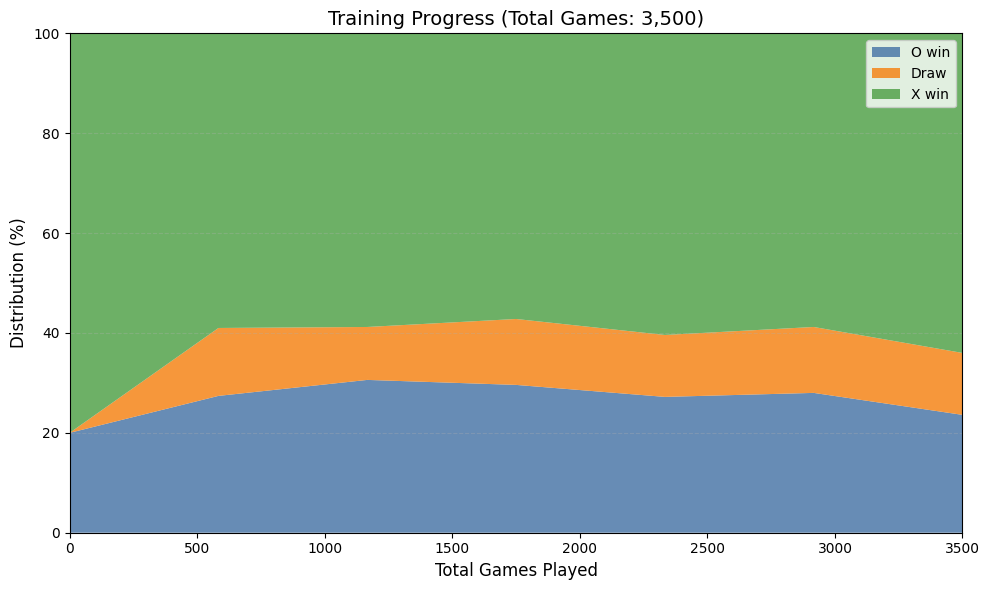

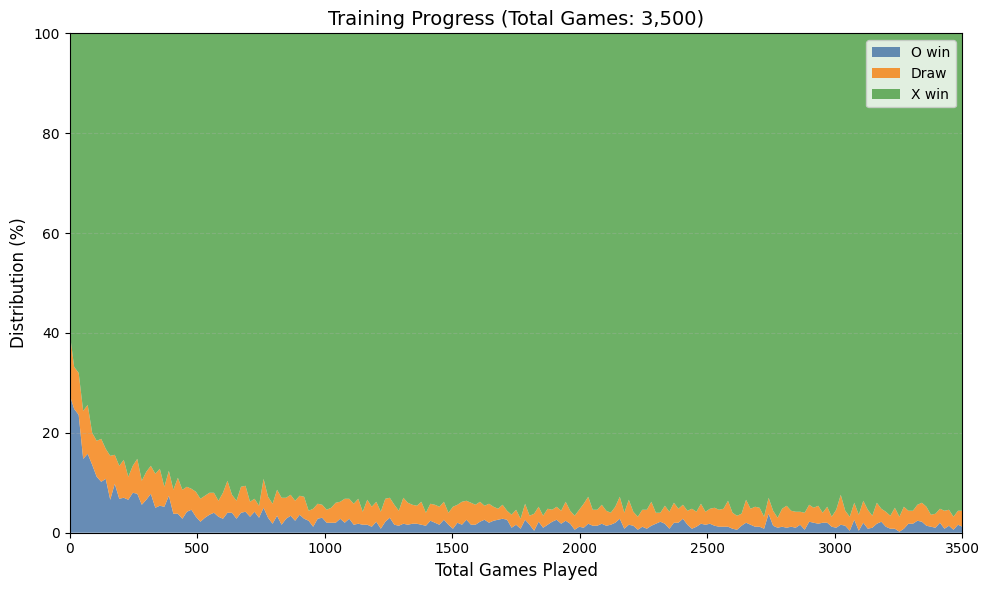

In [23]:

# Plot and compare
qlb.plot_training_results(results_td, BATCH_SIZE, NUMBER_OF_BATCHES)
qlb.plot_training_results(results_mc, BATCH_SIZE, NUMBER_OF_BATCHES)